In [1]:
%load_ext autoreload

%autoreload 2

%matplotlib inline

import os
import sys
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

#import pacmap
import umap
#import trimap
#import ivis
#import phate

#from scipy.stats import chisquare, chi2_contingency, pearsonr
#from scipy.stats import kendalltau,spearmanr, weightedtau, theilslopes, wilcoxon, ttest_rel
#from scipy.spatial import distance
#import dcor

from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, MDS, SpectralEmbedding
from sklearn.manifold import LocallyLinearEmbedding as LLE, TSNE, smacof, trustworthiness


#from sklearn.metrics import rand_score, adjusted_mutual_info_score, adjusted_rand_score
#from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
#from sklearn.neighbors import KNeighborsClassifier as KNN
#from sklearn.cluster import KMeans

#import numpy.linalg as la
#import torch 

#from numba import njit

#import faiss

from hembedder.utils import distance, hyperparameter_tuning, quality_metrics

c:\Users\bes3\VIRTUALENVS\embedder\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\bes3\VIRTUALENVS\embedder\lib\site-packages\torch\_masked\__init__.py:223: UserWarning: Failed to initialize NumPy: module compiled against API version 0xf but this version of numpy is 0xe (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:68.)
  example_input = torch.tensor([[-3, -2, -1], [0, 1, 2]])


In [2]:
cwd = os.getcwd()

Potential Embeddings to test:
* PCA (sklearn)
* SMACOF (sklearn)
* **LMDS** with exemplars for landmarking (local):
* LMVU (local):
* Sammon (local):
* GPLVM: 
* RankVisu:
* **UMAP**, [github](https://umap-learn.readthedocs.io/en/latest/index.html), [paper](https://arxiv.org/abs/1802.03426)
* **Parametric UMAP**, [github](https://umap-learn.readthedocs.io/en/latest/parametric_umap.html), [paper](https://arxiv.org/abs/2009.12981)
* **DenseMap**, part of UMAP library, [paper](https://www.biorxiv.org/content/10.1101/2020.05.12.077776v1)
* **IVIS**, [github](https://github.com/beringresearch/ivis), [paper](https://www.nature.com/articles/s41598-019-45301-0)
* **PHATE**, [github](https://phate.readthedocs.io/en/stable/), [paper](https://www.nature.com/articles/s41587-019-0336-3)
* **PACMAP**, [github](https://github.com/YingfanWang/PaCMAP), [paper](https://jmlr.org/papers/v22/20-1061.html)
* **TriMap**, [github](https://github.com/eamid/trimap), [paper](https://arxiv.org/abs/1910.00204)
* HOPE, [github](https://github.com/palash1992/GEM), [paper](https://dl.acm.org/doi/abs/10.1145/2939672.2939751)
* opt-SNE, [github](https://github.com/omiq-ai/Multicore-opt-SNE), [paper](https://www.biorxiv.org/content/10.1101/451690v3)
* FactorizedEmbeddings,[github](https://github.com/TrofimovAssya/FactorizedEmbeddings), [paper](https://academic.oup.com/bioinformatics/article/36/Supplement_1/i417/5870511)
* **MCML**, [github](https://github.com/pachterlab/MCML)

Distances:
* Manhattan
* Poincare
* Mahalanobis
* Euclidean

Data:
* celldyn; 3 million samples, 100+ dimensions
* RNA expression; 1200 samples; 40.000 dimensions
* synthetic datasets

Metrics:
* **Distance correlation**
* Rank preservation
* **Jaccard-index** 
* Calinski-Harabasz
* Davies-Bouldin
* Adjusted Rand score
* **Adjusted mutual information**
* Trustworthiness
* **random triplet score**: rank preservation among random triplets
* **Overall rank preservation**

Table with the embeddings, the quality metrics for 
* ```n_components```
* ```n_neighbors```
* ```n_samples```

#### celldyn data

In [3]:
celldyn_full = pd.read_feather("L:\laupodteam\AIOS\Bram\data\CellDyn\celldyn_FULL_transformed_df.feather")
meas_columns = [c for c in celldyn_full.columns if 'c_b' in c or 'COMBO_' in c]
mode_columns = [c for c in celldyn_full.columns if 'c_m' in c]
alrt_columns = [c for c in celldyn_full.columns if 'alrt' in c.lower()]
c_s_columns = [c for c in celldyn_full.columns if 'c_s_' in c.lower()]
demo_columns = ['gender', 'age']

## Test embedding

In [4]:
embedder = umap.UMAP(n_components=6)
X_org = celldyn_full.sample(1000)[meas_columns]
X_emb = embedder.fit_transform(X_org)

In [5]:
from scipy.spatial.distance import pdist
import dcor

dists_org = pdist(X_org.values, metric='euclidean')
dists_emd = pdist(X_emb, metric='euclidean')
dcor.distance_correlation(dists_org, dists_emd), dcor.distance_correlation(X_org, X_emb)

(0.5755579738705427, 0.8644618602788745)

In [6]:
d1list = []
d2list = []
for _ in range(20):
    indcs = np.random.randint(0, 1000, 1000)
    dists_org = pdist(X_org.values[indcs,:], metric='euclidean')
    dists_emd = pdist(X_emb[indcs,:], metric='euclidean')
    d1 = dcor.distance_correlation(dists_org, dists_emd)
    d2 = dcor.distance_correlation(X_org.values[indcs,:], X_emb[indcs,:])
    d1list.append(d1)
    d2list.append(d2)


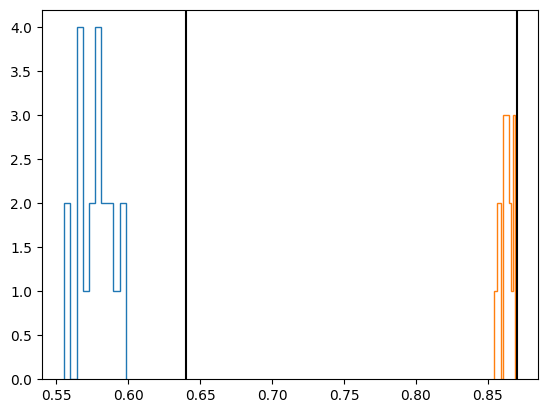

In [7]:
plt.hist(d1list, histtype='step');
plt.hist(d2list, histtype='step');
plt.axvline(0.64, color='black')
plt.axvline(0.87, color='black')

## Parameter sweep definition

In [8]:
samples = [80000]
samples.reverse()

param_grid = {    
    'n_neighbors' : [5, 15, 30, 50, 100, 160]
}
components = [2, 4, 6, 8, 16, 32]

distance_metric = 'manhattan' # cosine, euclidea n, manhattan, distance.poincarre_dist
metric_chuck_size = 5000

In [9]:
evaluate_n_n_default = quality_metrics.CDEmbeddingPerformance(dcor_level=2, n_neighbours=15, metric='manhattan')
evaluate = quality_metrics.CDEmbeddingPerformance(dcor_level=1, n_neighbours=100, metric='manhattan')

evaluators = {'Trustworthiness': evaluate._return_trustworthiness,
              'Distance correlation': evaluate._return_distance_correlation,
              'Distance correlation-correlation': evaluate_n_n_default._return_distance_correlation,
              'Random_triplets' : evaluate.random_triplet_eval,
              'neighbor_kept_ratio' : evaluate.neighbor_kept_ratio_eval,
              'neighbor_kept_15' : evaluate_n_n_default.neighbor_kept_ratio_eval}

## Embedder invocation

In [10]:
embedder = umap.UMAP
kwargs = {  
            'metric' : distance_metric, 
            'output_metric': distance_metric,
            'n_jobs' : 8, 
            'n_epochs' : 500, 
            'init' : 'spectral', 
            'densmap': False,
            'dens_lambda' : 0.1, 
            'dens_frac' : 0.1, 
            'repulsion_strength' : 1.1, 
            'negative_sample_rate' : 10, 
            'random_state' : 42,
            'min_dist' : 0.0,
            'low_memory' : False
}

## Run sweep

In [12]:
for s in samples:
    for nc in components:
        kwargs['n_components'] = nc
        tuning = hyperparameter_tuning.Hyperparameter_tuning(celldyn_full[meas_columns],
                                                            embedder,
                                                            evaluators=evaluators,param_grid=param_grid,
                                                            ascending=False, 
                                                            file_name=os.path.join(cwd, f"../artifacts/run_sweep_emb{s}_eval{metric_chuck_size}_{distance_metric}.csv"),
                                                            sample_size=s,
                                                            standardised=False, 
                                                            num_iter=1,
                                                            metric_chuck_size=metric_chuck_size,
                                                            n_parjobs = 8, 
                                                            **kwargs)
        _ = tuning.grid_search()

Total number of embedding runs :  6 (combos)x10(iterations) with [320000] sample_size for the embedding. Exceptions will be raised, if sample  size is larger than data size which is 3093792


  0%|          | 0/5 [00:00<?, ?it/s]c:\Users\bes3\VIRTUALENVS\embedder\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\bes3\VIRTUALENVS\embedder\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\bes3\VIRTUALENVS\embedder\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\bes3\VIRTUALENVS\embedder\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\bes3\VIRTUALENVS\embedder\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral e